# The Basics of Pulsar Timing

## Introduction

The power of pulsar timing comes from the ability to precisely predict when pulses will arrive at our telescope. The "timing model" combines parameters describing how the pulsar spins, how the pulsar moves across the sky, how the pulsar orbits around a companion, and how the interstellar medium affects the intrinsic pulse as it propagates through. We can visualize this as follows:


![timing model](images/timing.png)

We see that we must account for the position of the telescope on the Earth and as it goes around the Sun. Similarly, we need to account for where the pulsar is in its binary orbit. The arrows show that the two systems are moving with respect to each other in the Galaxy. And, as there is material in the interstellar medium, a single broadband pulse then spreads out in frequencies due to dispersion, such that longer wavelengths (red) arrive later than shorter wavelengths (blue).

![pulse train](images/pulse_train3.png)

A good model (*top*) will be able to predict when the pulses arrive exactly whereas a bad model (*middle*) will not. In that case, our mission is to "tweak" the parameters of the timing model until our predictions match the observed pulses (*bottom*). The difference between the observed time of arrival (TOA) of a pulse and the predicted arrival time is known as a timing residual, and plots of residuals help us visualize whether or not we have a good model or not.

In this exercise, you will see how different timing parameters change the timing residuals when they are slightly incorrect, and then slowly build up a good timing model. To do the analysis, you will use the PINT timing package to both simulate TOAs and then model them. Along the way, you'll determine some interesting astrophysics about your pulsar.

In [1]:
# Useful imports

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from io import StringIO
import pint
import pint.fitter
from pint.models import get_model
from pint.residuals import Residuals
from pint.simulation import make_fake_toas_uniform
import pint.logging

pint.logging.setup(level="ERROR")

1

We're going to use the functions defined below just for ease. You won't have to adjust them for any part of this exercise but can if you'd like to at any point in time.

`make_model()` will generate a PINT timing model object - if you don't know what this means just yet, that's okay, you will learn more in the second tutorial. The inputs specify the parameters describing how the pulsar behaves.

write out a pulsar parameter (par) file. It will include a couple of basic lines at top and then will simply write whatever string you want to the file. We'll see more about this in a moment. By default, it will output a par file with the name "mytiming.par".

`make_TOAs()` will take a model object and simulate TOAs.

`do_timing()` will take the TOAs and the model, time the pulsar, and by default produce a plot of the residuals for you. It returns the "best fit" model if `fit=True` is provided as an argument.

In [2]:
# Helper functions
def make_model(string):
    par_sim = """MODE 1
PSR      J0000+0000
PEPOCH    50000.0
"""
    par_sim += string
    return get_model(StringIO(par_sim))
def make_TOAs(model):
    t = make_fake_toas_uniform(startMJD=53000,
                               endMJD=56000,
                               ntoas=200,
                               fuzz = 1 * u.d,
                               model=model,
                               error=0.1 * u.us,
                               add_noise=True,
                               name="fake",
                               include_bipm=True
                              )
    return t
def do_timing(t, m, fit=False, plot=True):
    f = pint.fitter.Fitter.auto(t, m)
    if fit:
        f.fit_toas()
    rs = f.resids.time_resids.to(u.us).value
    xt = t.get_mjds()
    err = t.get_errors().to(u.us).value
    if plot:
        plt.figure()
        plt.errorbar(xt, rs, yerr=err, fmt=".")
        plt.xlabel("MJD")
        plt.ylabel(r"Residual ($\mu$s)")
        plt.grid()
        plt.show()
    if fit:
        return f.model

To begin, we're going to make an unmoving, spinning pulsar with spin period $P = 15$~ms, or a spin frequency of $f = 66.66\bar{6}$ Hz, which we will use because it is often the more fundamental quantity (written as "F0" in a par file, this formulation is better in timing in general). First we'll make the model and then we'll simulate the corresponding arrival times.

In [3]:
m = make_model("F0       66.66666667") 
t = make_TOAs(m)

Now let's use PINT to show how well the spin period fits the TOAs.

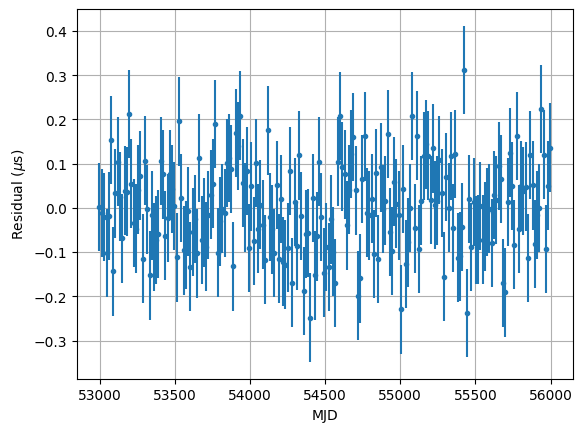

In [4]:
do_timing(t, m)

What do you notice about the residuals? Do you think this is a reasonable fit? Why or why not? Feel free to record your answers in the box(es) provided.

Now let's see what happens when we change the spin frequency ever so slightly. Try taking the code below and adding just 10 nanohertz to the spin frequency (1 to the last digit above) in the model and then replotting the residuals *without( changing the simulated TOAs.

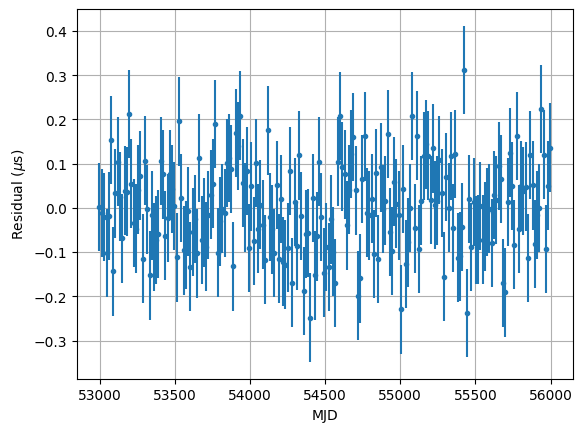

In [5]:
# Add your adjusted line of code right below:

do_timing(t, m)

What do you notice is happening? Why is the pattern like that?

Now try again in the cell above but instead add just 1 nanohertz to the initial spin period. Now what happens?

Now let's learn how to fit the parameter for the spin period. To do this, we add a "1" after the value of the parameter, which for par files means that the parameter should be fit for. A "0" means to hold that value fixed, which is the same as not having a number there at all as we've been doing.

To do the fit we can supply the `fit=True` argument to the `make_plot()` function, like below. Note also now we will grab the resulting model so we can examine its components.

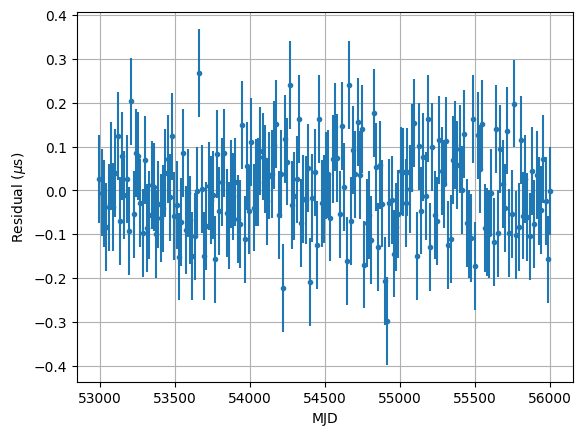

In [8]:
m = make_model("F0       66.666666671  1") 
result = do_timing(t, m, fit=True)

How well did the fit do? To see what the value of the spin period is, you have to print out the value of the spin frequency, which is $1/P$, since that is the more fundamental quantity. To show that value, print `result.F0`. In general, you can print `result.<parameter name>`. Try that below. You can also print the entire underlying model by simply printing `result`.

In [ ]:
# Some space for you to work


We know that since pulsars are emitting radiation, they are losing energy and thus are slowing down. The spin frequency derivative, $\dot{f}$, is written in the par file as `F1`. The units on $\dot{f}$ are typically hertz per seconds, that is, how many hertz the pulsar is slowing down every second. As you might expect, it's a very tiny number. Let's first build our new model and make a new set of TOAs

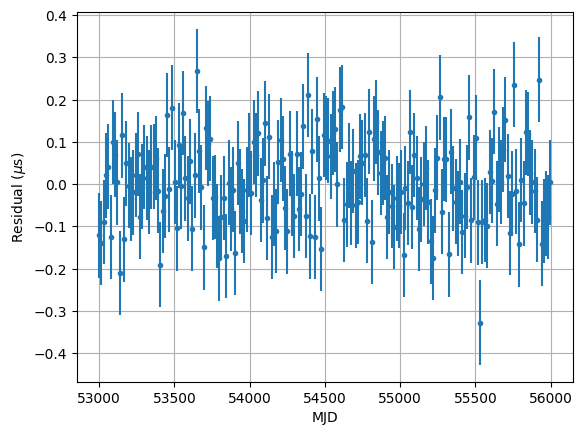

In [9]:
m = make_model("""
F0       66.66666667
F1      -1e-19
""")
t = make_TOAs(m)
result = do_timing(t, m)

Next, now change the spin frequency derivative ever so slightly, from $-1 \times 10^{-19}$ to $-1.1 \times 10^{-19}$.

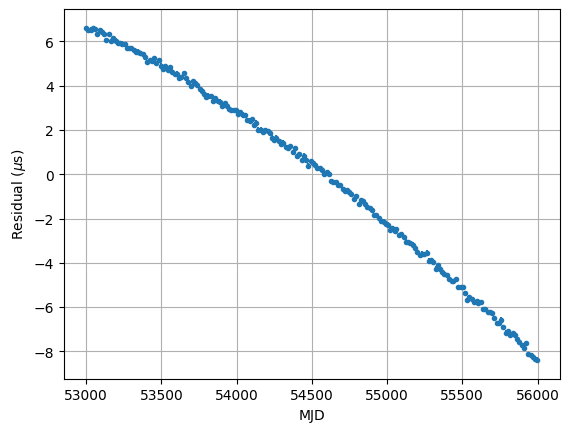

In [10]:
m = make_model("""
F0       66.66666667
F1      -1.1e-19
""")
result = do_timing(t, m)

What do you notice about the shape of the residuals? When $\dot{f}$ is incorrect, do the residuals look the same as when $f$ is incorrect?

In [ ]:
# Some space for you to work

Now try to fit both parameters and print the values of the parameters. How do they compare to the true values? Is the fit good?

In [ ]:
# Some space for you to work


Great, now you are an expert timer! Let's now add in the position of the pulsar. We'll write in the right ascension (RA) and declination (DEC) of one of NANOGrav's best pulsars (in the J2000 coordinate system) by adding to the par file   
`RAJ    19:09:00`   
and   
`DECJ    -37:44:00`.   
Copy the code above, make a new model and set of TOAs, and plot the results. As usual, you should start off with a good fit.

In [ ]:
# Some space for you to work


Now add 1 milliarcsecond (0.001) to the declination and see how that affects the fit.

In [ ]:
# Some space for you to work


What do you notice about the fit? What is the timescale of the variation? Any ideas why? Feel free to use the interactive figure to zoom in and investigate further if you need.

In [ ]:
# Some space for you to work


Again, let's now fit for all of the parameters. Do you get a good fit at the end?

In [ ]:
# Some space for you to work


The pulsar is at some distance from us, which produces a parallax. The units on the parallax are in milliarcseconds (mas). A pulsar with a parallax of 1 mas is at a distance of 1 kpc (kiloparsec). Let's put a pulsar at 0.5 kpc away, so it will have a parallax of 2.0 mas.

`PX     2.0`

Then let's see what happens when the pulsar is plotted with the wrong parallax, let's say 2.5 mas.

Instead of making two separate cells, let's condense our work into one cell. Now just call `make_model()` with the appropriate values, then `make_TOAs()`, then `make_model()` again with the slightly adjusted parallax before plotting the residuals with `do_timing()`.

In [ ]:
# Some space for you to work


What do you notice about the fit? What is the timescale of the variation?

It turns out that the "why" of this timescale is a little bit more complicated than for an incorrect pulsar position. It has to do with the fact that the pulsar emission arriving at the solar system is not a plane wave but there is some curvature to it. 

Yet again, let's fit all of the parameters. Then print out the parallax value. How does the precision on this value compare to some of the others you've examined?

In [ ]:
# Some space for you to work


Let's add one more set of astrometric terms, the proper motion in the RA and DEC directions. These are given in units of milliarcseconds per year (mas/yr). In the par file, we write `PMRA` and `PMDEC`. Set the true PMRA to 50.0 and the PMDEC to 0.0 just for ease. Then simulate your TOAs, mae a new par file with PMRA set to 50.1, and plot the results.

What do you notice about the residuals now? What is happening to the timescale of the variation? Any ideas as to why the structure of the residuals looks the way it does?

In [ ]:
# Some space for you to work


Once again, let's do the fit! Check to see if the values of the proper motion make sense.

In [ ]:
# Some space for you to work


Excellent! You now have a description of this pulsar that accounts for the spin dynamics of the pulsar and the astrometry. Let's do some science with our numbers!

First, to make things easy, let's convert from $f$ and $\dot{f}$ to $P$ and $\dot{P}$. We have by definition that the spin period and frequency are related by $P = 1/f$. Using some calculus, then we have that

$$\frac{dP}{df} = -\frac{1}{f^2}$$

and therefore

$$\dot{P} = -\frac{\dot{f}}{f^2}$$.

Use the value of $P$ given above (or re-calculate it) and calculate $\dot{P}$. Note that the units of $\dot{P}$ are seconds per seconds.

In [ ]:
# Some space for you to work


Let's calculate the amount of energy lost by the system, given by (see Lorimer & Kramer 2005)

$$\dot{E} = 4 \pi^2 I \dot{P} P^{-3} \simeq 3.95 \times 10^{31}~\mathrm{erg~s^{-1}}\left(\frac{\dot{P}}{10^{-15}}\right)\left(\frac{P}{\mathrm{s}}\right)^{-3}$$

How does this compare to the luminosity of the Sun ($4.0 \times 10^{33}~\mathrm{ergs~s^{-1}}$)?

In [ ]:
# Some space for you to work


Now let's calculate the surface magnetic field of the pulsar, given by

$$ B_s = 3.2 \times 10^{19}~\mathrm{G} \sqrt{P \dot{P}} \simeq 10^{12}~\mathrm{G}~\left(\frac{\dot{P}}{10^{-15}}\right)^{1/2} \left(\frac{P}{\mathrm{s}}\right)^{1/2} $$

For reference, Earth's magnetic field is usually around $\lesssim 1~\mathrm{G}$!

In [ ]:
# Some space for you to work
